In [1]:
import os
import json
import time
import math
import matplotlib.pyplot as plt
from core.data_processor import DataLoader
from core.model import Model
import pandas as pd
import numpy as np


In [2]:
import tushare as ts
ts.set_token("4dfe93632a16f49cae109f45465cc2aa13e6151e3a879cfa23d71d72")
pro = ts.pro_api()

ts_code = '000001.SZ'
start_date = '20000701'
end_date = '20230718'

df = pro.daily(ts_code=ts_code, start_date=start_date, end_date=end_date)

In [97]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()
def plot_results(predicted_data, true_data):
    #平移1天预测数据，使其与真实数据对齐,在第一个位置插入0
    predicted_data = np.insert(predicted_data,0,0)
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.plot(predicted_data, '.-')

    plt.legend()
    plt.show()


In [ ]:
def model(data,input={
        "train_test_split": 0.8,
        "nero_num": 100,
        "dropout_rate": 0.2,
        "seq_len": 50,
    }):
    
    df=data
    #转换为Date,Open,High,Low,Close,Volume
    df = df.sort_values(by='trade_date', ascending=True)
    df = df[['trade_date','open','high','low','close','vol']]
    df.columns = ['Date','Open','High','Low','Close','Volume']
    #去掉索引
    df = df.reset_index(drop=True)

    #预览
    df.head()
    #保存为csv
    path = 'data/stoke.csv'
    df.to_csv(path,index=False)


    #修改config.json中的参数
    with open('config.json') as f:
        config = json.load(f)
        #data.filename
        config['data']['filename'] = 'stoke.csv'
        #data.train_test_split
        config['data']['train_test_split'] = input['train_test_split']
        #data.sequence_length
        config['data']['sequence_length'] = input['seq_len']
        config["model"]["layers"][0]["input_timesteps"] = input['seq_len']-1
        #dropout_rate,nero_num
        #所有的dropout_rate都改,所有的nero_num都改
        for i in range(len(config["model"]["layers"])):
            if(config["model"]["layers"][i]["type"]=="dropout"):
                config["model"]["layers"][i]["rate"] = input['dropout_rate']
            elif(config["model"]["layers"][i]["type"]=="lstm"):
                config["model"]["layers"][i]["neurons"] = input['nero_num']




    #保存修改后的config.json
    with open('config.json','w') as f:
        json.dump(config,f,indent=4)

    #
    configs = json.load(open('config.json', 'r'))
    if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

    #加载数据
    data = DataLoader(
        os.path.join('data', configs['data']['filename']),
        configs['data']['train_test_split'],
        configs['data']['columns']
    )
    #构建模型
    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )


    #训练模型

    '''
    # in-memory training
    model.train(
        x,
        y,
        epochs = configs['training']['epochs'],
        batch_size = configs['training']['batch_size'],
        save_dir = configs['model']['save_dir']
    )
    '''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )



    #预测
    #计算准确率
    #取最后一段长为sequence_length的数据
    #1by1
    x_test=x[-configs['data']['sequence_length']:]
    y_test=y[-configs['data']['sequence_length']:]
    predictions = model.predict_point_by_point(x_test)
    mse_last_seq_day = np.mean(np.square(predictions - y_test))
    print("LSTM:最后一段长为sequence_length的数据的mse为:{}".format(mse_last_seq_day))

    #预测结果(往后sequence_length天的预测结果)
    predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
    predictions = np.array(predictions)[0]
    predictions = predictions[0:21]
    #plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])


    #predictions = predictions[0]
    #只根据预测结果的第一天和预测结果的平均值,返回1(涨)或者0(跌)
    average = np.average(predictions)
    print("LSTM:预测结果的平均值(normalised)为:{}".format(average))
    print("LSTM:预测结果的第一天(normalised)为:{}".format(predictions[0]))

    if(predictions[0]>average):
        print("LSTM:预测结果为:涨")
        return 1,mse_last_seq_day,predictions
        
    else:
        print("LSTM:预测结果为:跌")
        return 0,mse_last_seq_day,predictions




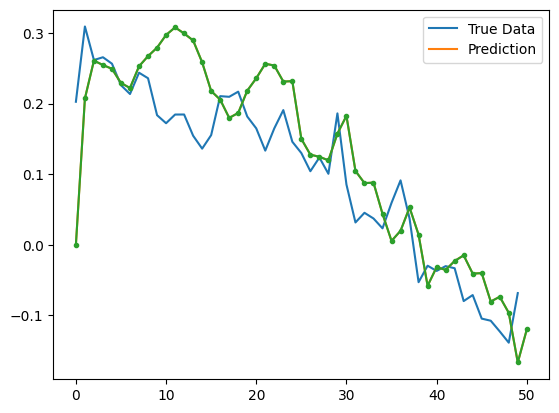

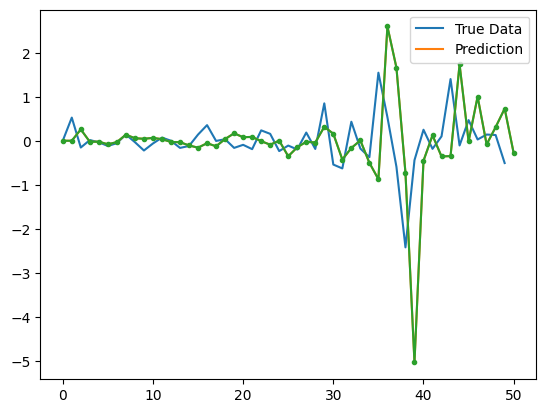

<Axes: >

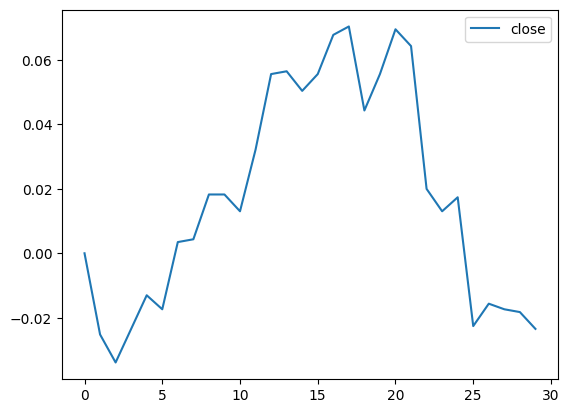

In [104]:
plot_results(predictions, y_test)
#再绘制相对于上一天的涨跌幅
predictions_relative = predictions.copy()
predictions_relative[0] = 0
for i in range(1,len(predictions_relative)):
    predictions_relative[i] = predictions[i]-predictions[i-1]
    predictions_relative[i] = predictions_relative[i]/predictions[i-1]

y_test_relative = y_test.copy()
y_test_relative[0] = 0
for i in range(1,len(y_test_relative)):
    y_test_relative[i] = y_test[i]-y_test[i-1]
    y_test_relative[i] = y_test_relative[i]/y_test[i-1]

plot_results(predictions_relative, y_test_relative)



#往后获取50天的数据
end_date_50 = '20230828'
real_data = pro.daily(ts_code=ts_code, start_date=end_date, end_date=end_date_50)
#获取close列
real_data = real_data[['close']]
#normalise(以相对于第一天的涨跌幅表示)
real_data['close'] = (real_data['close']-real_data['close'][0])/real_data['close'][0]
#plot
real_data.plot()



LSTM（长短期记忆）是一种特殊的循环神经网络（RNN），它可以在长序列中学习和记忆信息。LSTM的关键在于其细胞状态，这是一种横跨各个时间步的“记忆”线，信息可以在其中无损地流动。

LSTM通过三个重要的门控制器（输入门、遗忘门和输出门）来更新和控制细胞状态。这些门控制器是一种特殊的结构，它们可以学习何时添加、保留或删除信息。

1. 输入门决定我们将在当前时间步长接收哪些新信息。
2. 遗忘门决定我们将保留或丢弃哪些过去的信息。
3. 输出门决定基于当前的细胞状态，我们将输出什么样的信息。

LSTM的这种结构使其能够捕捉和学习长期依赖性，这是许多其他类型的RNN难以做到的。因此，LSTM在处理序列预测、自然语言处理、时间序列分析等任务时表现出色。